# Stochastic Volatility model

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(r_i) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $r$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [3]:
n = 400
returns = pd.read_hdf('../data/assets.h5', key='sp500/prices').loc['2000':, 'close'].pct_change().dropna()
returns[:5]

date
2000-01-04   -0.038345
2000-01-05    0.001922
2000-01-06    0.000956
2000-01-07    0.027090
2000-01-10    0.011190
Name: close, dtype: float64

As you can see, the volatility seems to change over time quite a bit but cluster around certain time-periods. Around time-points 2500-3000 you can see the 2009 financial crash.

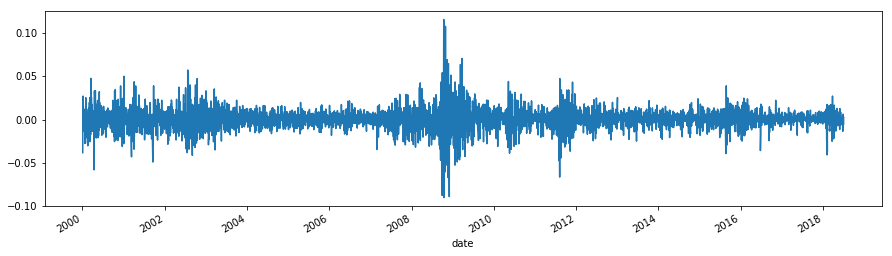

In [5]:
returns.plot(figsize=(15,4))

Specifying the model in `PyMC3` mirrors its statistical specification. 

In [9]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size, shape=len(returns))
    
    nu = pm.Exponential('nu', .1)
    r = pm.StudentT('r', nu=nu, lam=pm.math.exp(-2*s), 
                    observed=returns)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. NUTS, however, gives the correct posterior.

In [10]:
with model:
    trace = pm.sample(tune=2000, nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, s, sigma]
Sampling 4 chains: 100%|██████████| 10000/10000 [45:07<00:00,  4.76draws/s] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


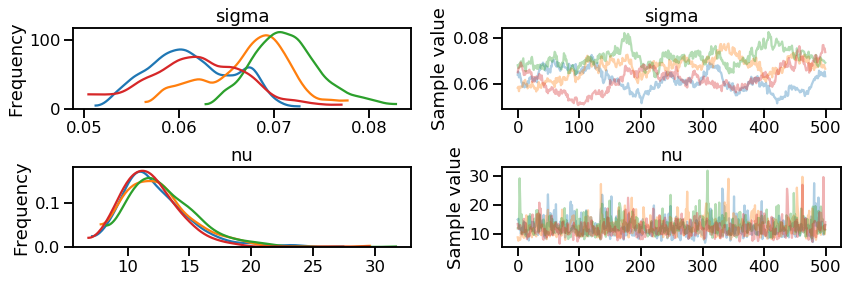

In [12]:
pm.traceplot(trace, varnames=['sigma', 'nu']);

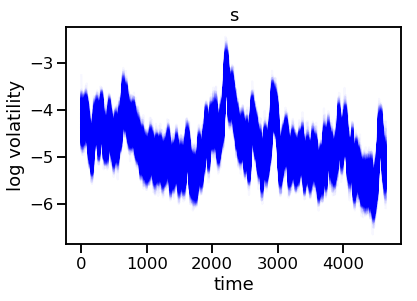

In [13]:
fig, ax = plt.subplots()

plt.plot(trace['s'].T, 'b', alpha=.03);
ax.set(title=str(s), xlabel='time', ylabel='log volatility');

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

In [19]:
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 4656 entries, s__0 to nu
dtypes: float64(4656)
memory usage: 71.0 MB


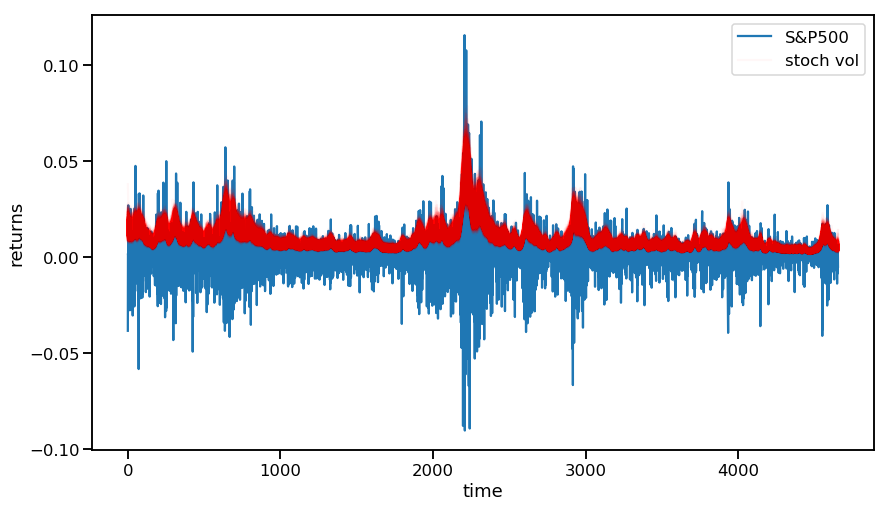

In [36]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns.values)
ax.plot(np.exp(trace[s]).T, 'r', alpha=.03);
ax.set(xlabel='time', ylabel='returns')
ax.legend(['S&P500', 'stoch vol']);

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 